<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/01_nice_rot_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import imutils

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [2]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx]
        return x

In [3]:

class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)

        self.per_list = self.permutation()

    def forward(self, x):
        x = x.view(len(x), -1,).to(torch.float32)
        return self.f(x)

    def permutation(self):
        per_list =[]

        p = torch.eye(self.input_dim)
        for flow in range(self.num_flows):
            per_list.append(p[torch.randperm(p.size()[0])])

        return per_list

    def coupling_layer(self, x, m, flow, forward=True):

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a

        return z


    def f(self, x):
        z = x / torch.exp(self.s)

        for flow, model in enumerate(self.m, start=0):
            z = torch.matmul(z, self.per_list[flow])
            z = self.coupling_layer(z, model, flow, forward=True)

        log_det_j = torch.sum(self.s)

        return z, log_det_j

    def f_inv(self, z):

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            z = self.coupling_layer(z, model, flow, forward=False)
            z = torch.matmul(z, self.per_list[flow].T)

        x = z * torch.exp(self.s)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) - log_det_j).mean()
        return loss

In [4]:
def rescale(x, lo, hi):
    """Rescale a tensor to [lo,hi]."""
    assert(lo < hi), "[rescale] lo={0} must be smaller than hi={1}".format(lo,hi)
    old_width = torch.max(x)-torch.min(x)
    old_center = torch.min(x) + (old_width / 2.)
    new_width = float(hi-lo)
    new_center = lo + (new_width / 2.)
    # shift everything back to zero:
    x = x - old_center
    # rescale to correct width:
    x = x * (new_width / old_width)
    # shift everything to the new center:
    x = x + new_center
    # return:
    return x

In [5]:
digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target,
                                                    stratify=digits.target,
                                                    test_size=0.20,
                                                   random_state=42)

#X_train = (X_train - X_train.min()) / (X_train.max()-X_train.min())

# Dequantization
X_train = torch.tensor(X_train) + torch.rand_like(torch.tensor(X_train)).div_(256.)
X_train = rescale(X_train, 0., 1.).numpy()

#train_data = Data(X_train)

In [6]:
list_train = []
list_y_train = []

for i in range(10):
  random = np.random.randint(0,140,30) # gives 30 integers betw. 0 and 140

  list_train.append(X_train[y_train[:]==i][random])
  list_y_train.append([y_train[y_train[:]==i][random]])



gen_train = torch.tensor(np.array(list_train)).reshape(300,64)
gen_y_train = torch.tensor(np.array(list_y_train)).reshape(300)


Text(0.5, 1.0, '9')

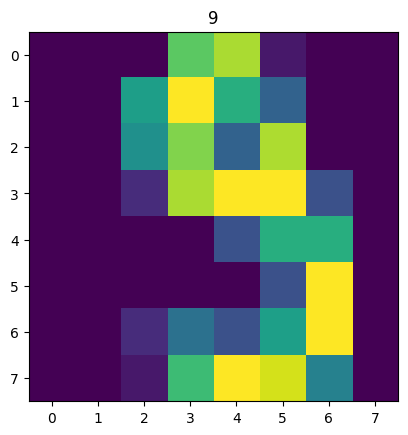

In [7]:
image=299
plt.imshow(gen_train[image].reshape(8,8))
plt.title('{}'.format(gen_y_train[image]))

In [8]:
for i in range(len(gen_train)):
  for j in [90,180,270]:
    rotated_im = imutils.rotate(gen_train[i].numpy().reshape(8,8), angle=j).reshape((1,64))
    gen_train = torch.cat((gen_train, torch.tensor(rotated_im)), 0)
    gen_y_train = torch.cat((gen_y_train, gen_y_train[i].reshape((1))), 0)

In [9]:
train_data = Data(gen_train)

Text(0.5, 1.0, '9')

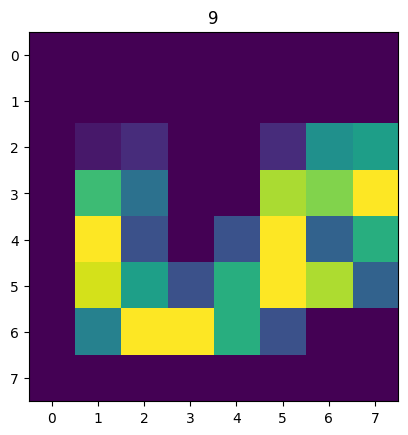

In [10]:
image=1199
plt.imshow(gen_train[image].reshape(8,8))
plt.title('{}'.format(gen_y_train[image]))

In [11]:
data_dim = 8*8

prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))
"""
prior = torch.distributions.normal.Normal(loc=torch.zeros((data_dim)),
                                                    scale=torch.ones((data_dim)))
"""
model = NICE(input_dim=data_dim, hidden_layer=256, num_flows=10)

train_loader = DataLoader(train_data, batch_size=250, shuffle=True)


In [12]:
epochs = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%100 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))


Epoch :  1   -----------> Loss :  154.59291381835936
Epoch :  100   -----------> Loss :  51.989611053466795
Epoch :  200   -----------> Loss :  6.705622863769531
Epoch :  300   -----------> Loss :  -30.355122375488282
Epoch :  400   -----------> Loss :  -57.980116271972655
Epoch :  500   -----------> Loss :  -75.6606689453125
Epoch :  600   -----------> Loss :  -93.32415618896485
Epoch :  700   -----------> Loss :  -114.46843872070312
Epoch :  800   -----------> Loss :  -119.392724609375
Epoch :  900   -----------> Loss :  -131.54460906982422
Epoch :  1000   -----------> Loss :  -138.43665466308593


In [13]:
test = prior.sample((50,))
test

tensor([[ 0.8701,  0.1678, -1.4492,  ...,  1.0005,  2.7364,  0.2110],
        [-0.0505, -0.2196,  0.1902,  ...,  0.5723, -1.3384,  0.8121],
        [ 1.0215,  0.3657,  1.4564,  ..., -0.6506,  0.1521, -0.2480],
        ...,
        [ 0.4227,  0.0115, -0.2850,  ..., -0.0357,  1.6315, -0.4660],
        [-0.3065, -0.0029,  1.3721,  ...,  0.1985, -1.0264, -0.9174],
        [-1.0328, -1.1971, -2.2188,  ...,  0.2372,  1.0318,  1.2058]])

In [14]:

sonuc = model.f_inv(test)
sonuc


tensor([[ 9.4014e-06,  2.6009e-04, -8.2600e-03,  ...,  3.0694e-02,
          2.0621e-02,  1.8844e-03],
        [ 9.4617e-05, -1.1280e-02,  3.3989e-01,  ...,  4.4905e-01,
          8.7520e-01,  8.7967e-01],
        [-1.1519e-05,  1.8889e-03, -1.4763e-02,  ...,  2.0097e-03,
          2.8875e-03, -1.5319e-02],
        ...,
        [-6.7698e-06,  1.9809e-03, -2.5387e-02,  ...,  4.5744e-03,
          1.5558e-03, -2.7096e-02],
        [-7.5738e-06,  1.6709e-03, -3.4790e-02,  ..., -6.4061e-02,
         -5.1338e-02,  8.1495e-03],
        [-1.1331e-05, -1.7050e-02, -4.6289e-02,  ..., -4.4961e-02,
          1.4457e-03, -1.1646e-02]], grad_fn=<MulBackward0>)

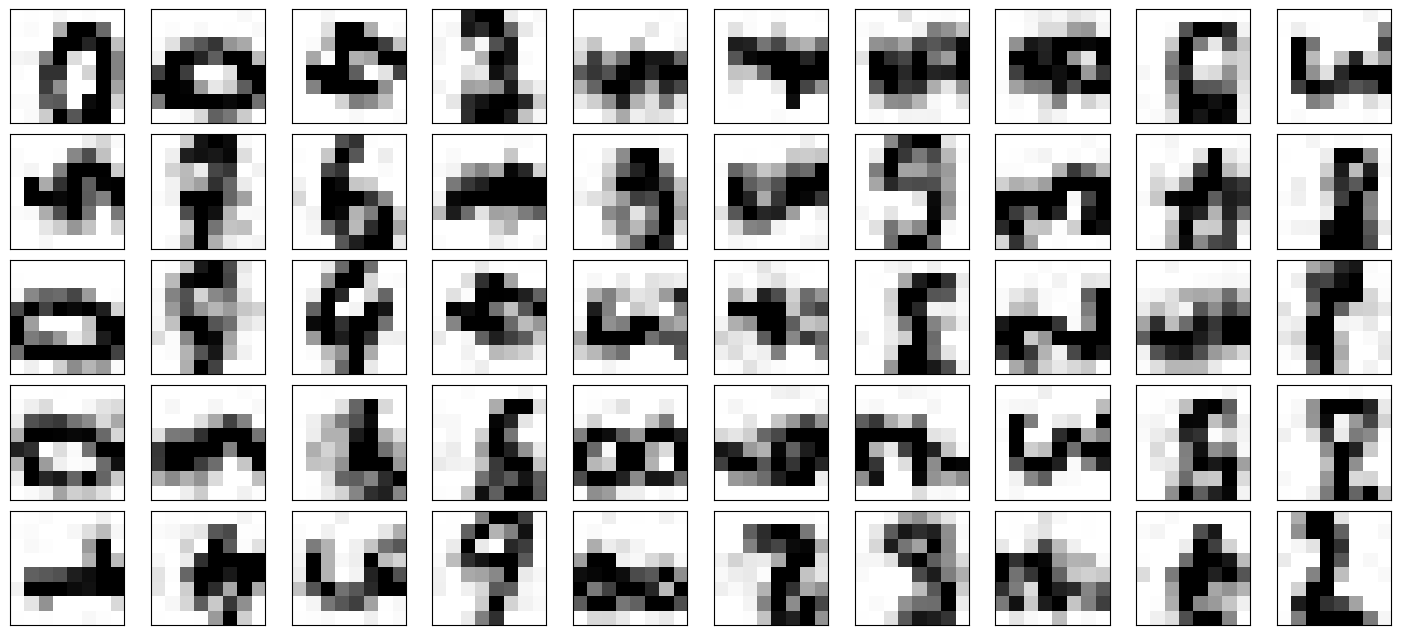

In [15]:
test = prior.sample((1797,))
sonuc = torch.nn.ReLU()(model.f_inv(test))

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
fig.show()

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
#pca.fit(sonuc)

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
#pca.fit(sonuc)

In [18]:
forward, logdet_j = model.forward(torch.tensor(gen_train))
backward = model.f_inv(forward)

<ipython-input-18-47850105f502>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  forward, logdet_j = model.forward(torch.tensor(gen_train))


In [19]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(backward.detach().numpy())          #sonuc.detach().numpy()
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1200, 2)


In [20]:
projected_raw = pca.fit_transform(gen_train)          #sonuc.detach().numpy()
print(digits.data.shape)
print(projected_raw.shape)

(1797, 64)
(1200, 2)


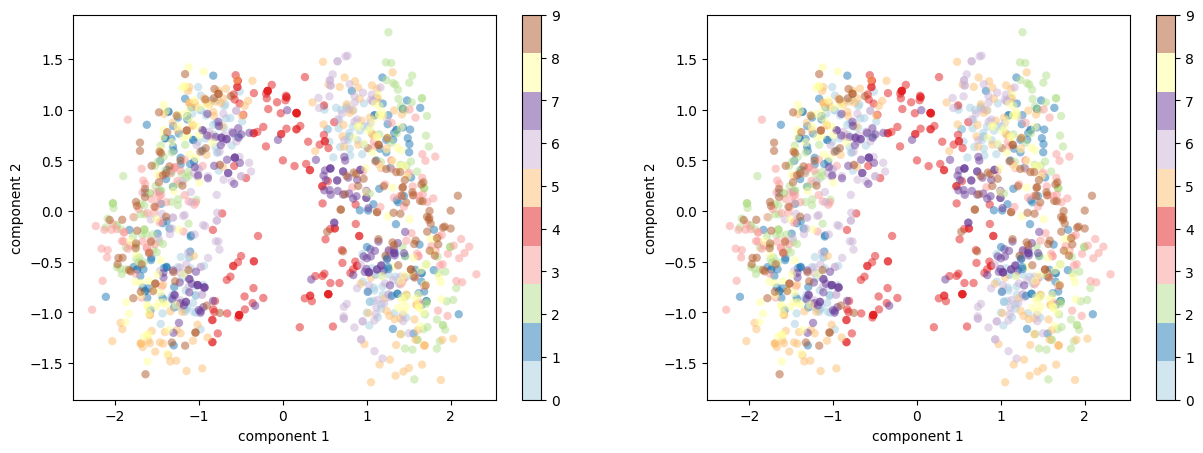

In [21]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1, 2, 1)
im1 = ax1.scatter(projected_raw[:, 0], projected_raw[:, 1],
            c=gen_y_train, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Paired', 10))
ax1.set_xlabel('component 1')
ax1.set_ylabel('component 2')
plt.colorbar(im1, ax=ax1)

ax2 = fig.add_subplot(1, 2, 2)
im2 = ax2.scatter(projected[:, 0], projected[:, 1],
            c=gen_y_train, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Paired', 10))
ax2.set_xlabel('component 1')
ax2.set_ylabel('component 2')
plt.colorbar(im2, ax=ax2)

plt.show()